In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import time
from scipy.special import expit, logit
import warnings
import joblib
import pickle
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
warnings.filterwarnings('ignore')
import os
import json
from datetime import datetime

prop_list = ['soc', 'ocd','bulk.density.fe','ph.cacl2', 'ph.h2o','total.n', 'carbonates','extractable.p', 'extractable.k','cec'] #'coarse.mass', 'coarse.vol', 'bulk.density.tot', 'ec', 

space_list = ['log1p','log1p','normal','normal','normal','log1p','log1p','log1p','log1p','log1p'] 
version = '20250212'

df = pd.read_parquet(f'/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/soil_property_model_pipeline/soil_organized.pq')
data_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/soil_property_model_pipeline'

In [2]:
df['ocd_qa'] = 5

# Separate Calibration (Cal), Train, and Test Data

Perform this separation **only once**, then save and read the separated data to ensure reproducibility.

#### Data ratio:
- **When data is limited**: Maintain the ratio between calibration, train, and test sets as `1:8:1`.
- **When data is abundant**: Allocate around **8,000 samples** for calibration and **6,000 samples** for testing.

#### How:
- **Strata with very few samples** (`count < 3`): Randomly assign samples to a set.
- **Strata with few samples** (`3 ≤ count < 10`): Distribute samples evenly across the sets.
- **Strata with sufficient samples** (`count ≥ 10`): Assign samples according to the specified ratio.


In [3]:

for ii in [1]: #range(len(prop_list)):
    
    prop = prop_list[ii]
    print(f'\n{prop}--------------------------------------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    cal, train, test = separate_data(prop, space, output_folder, version, df, strata_col = ['tile_id'])


ocd--------------------------------------------------------------
drop invalid 362049 records
143 small strata groups, with 591 data records
size: calibration 5379, training 37154, test 4787
ratio: calibration 0.11, training 0.79, test 0.10
sum 47320, df 47320


# Feature selection

total cov number:  593

ocd--------------------------------------------------------------
start bootstrap on different subset...
[10:02:56] 0 iteration, training size: 3746
[10:03:01] 1 iteration, training size: 3746
[10:03:06] 2 iteration, training size: 3746
[10:03:12] 3 iteration, training size: 3746
[10:03:17] 4 iteration, training size: 3746
[10:03:22] 5 iteration, training size: 3746
[10:03:28] 6 iteration, training size: 3746
[10:03:33] 7 iteration, training size: 3746
[10:03:39] 8 iteration, training size: 3746
[10:03:44] 9 iteration, training size: 3746
[10:03:50] 10 iteration, training size: 3746
[10:03:55] 11 iteration, training size: 3746
[10:04:00] 12 iteration, training size: 3746
[10:04:06] 13 iteration, training size: 3746
[10:04:11] 14 iteration, training size: 3746
[10:04:16] 15 iteration, training size: 3746
[10:04:22] 16 iteration, training size: 3746
[10:04:27] 17 iteration, training size: 3746
[10:04:32] 18 iteration, training size: 3746
[10:04:38] 19 iteration, t

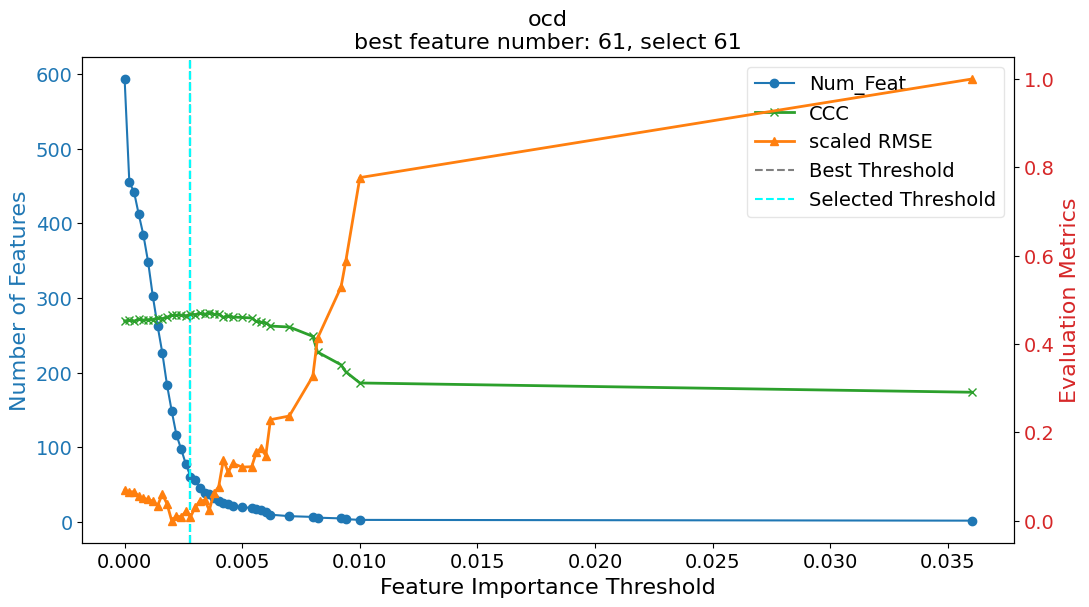

In [4]:
with open(f'/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/soil_property_model_pipeline/cov_all.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

for ii in [1]: #range(1,len(prop_list)):
    
    prop = prop_list[ii]
    print(f'\n{prop}--------------------------------------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    # os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    # read existing results
    cal = pd.read_parquet(f'{output_folder}/data_cal_{prop}_v{version}.pq')
    
    # # feature selection
    # print('feature selection********************')
    cfi = cfi_calc(cal, tgt, prop, space, output_folder, version, covar_cols) 
    # cfi = pd.read_csv(f'{output_folder}/feature_cfi_{prop}_v{version}.csv') # read in
    covs = rscfi(cal, tgt, prop, space, output_folder, version, covar_cols, cfi)


# Hyper-parameter fine tuning

In [5]:
# model calibration

for ii in [1]:#range(0,len(prop_list)): 
    
    prop = prop_list[ii]
    print(f'\n{prop}--------------------------------------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    # os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
        
    cal = pd.read_parquet(f'{output_folder}/data_cal_{prop}_v{version}.pq')
    # 
    # covs = rscfi(cal, tgt, prop, space, output_folder, version, covar_cols, cfi, min_convs_num, step_size=0.0002) # produce
    
    # ## read in existing results
    covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    ## parameter fine-tuning
    print('parameter fine tuning****************')
    models, model_names = parameter_fine_tuning(cal, covs, tgt, prop, output_folder, version)


ocd--------------------------------------------------------------
parameter fine tuning****************
[10:09:38] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 66
max_resources_: 5365
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 66
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 198
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 594
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 1782
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 5346
Fitting 5 folds for each of 2 candidates, totalling 10 fits
